### Modeling for trivia questions exploration

##### In this notebook, we will finetune T5 on trivia dataset.

##### T5 [(Text-To-Text Transfer Transformer)](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html) model is for all practical purposes the original Transformer model trained on a new dataset called Colossal Clean Crawled Corpus, aka C4.

##### Information about Trivia dataset used: http://nlp.cs.washington.edu/triviaqa/

- I will accessing trivia_qa through HuggingFace Datasets
- But Tensorflow page has better documentation about the dataset arguments: https://www.tensorflow.org/datasets/catalog/trivia_qa
- Use this script to evaluate: https://github.com/mandarjoshi90/triviaqa/blob/master/evaluation/triviaqa_evaluation.py
- State of the art F1 scores tracked here: https://competitions.codalab.org/competitions/17208


##### Some relevant text from [HuggingFace](https://huggingface.co/transformers/model_doc/t5.html#overview):
- T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format. T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: ….

- For sequence-to-sequence generation, it is recommended to use T5ForConditionalGeneration.generate(). This method takes care of feeding the encoded input via cross-attention layers to the decoder and auto-regressively generates the decoder output.

### 0. Installations and Import

In [ ]:
!pip install transformers
!pip install datasets   # https://github.com/huggingface/datasets
!pip install pytorch-lightning

In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

import transformers
from transformers import (
    T5Tokenizer,
    AutoTokenizer,
    T5ForConditionalGeneration,
    T5Config,
    AdamW, 
    Adafactor,
    get_linear_schedule_with_warmup
)

from datasets import (
    list_datasets,
    load_dataset,
    list_metrics,
    load_metric)

import json
import os
import re
import argparse
import random
import time
import string
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler

import matplotlib.pyplot as plt
import argparse

## Colab accessing Google drive
from google.colab import drive
drive.mount('/content/drive')

##### **`from transformers import` Notes**
- Import tokenizer for formatting input text. Has to be model specific because we are finetuning it and we need to use the token used while training. Or, use `AutoTokenizer` to pick the right one.
- T5ForConditionalGeneration: actual model that we need to finetune
- Model specific config that has model specific data like vocab_size, size of encoder layers, etc.
- [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw-pytorch): one kind of Adam
- [Adafactor](https://www.paperswithcode.com/method/adafactor): another kind of Adam that takes less memory. :D
- get_linear_schedule_with_warmup is the learning_rate modifier.

In [3]:
datasets = list_datasets()
print(list(datasets))

['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews', 'allocine', 'alt', 'amazon_polarity', 'amazon_reviews_multi', 'amazon_us_reviews', 'ambig_qa', 'amttl', 'anli', 'app_reviews', 'aqua_rat', 'aquamuse', 'ar_cov19', 'ar_res_reviews', 'ar_sarcasm', 'arabic_billion_words', 'arabic_pos_dialect', 'arabic_speech_corpus', 'arcd', 'arsentd_lev', 'art', 'arxiv_dataset', 'aslg_pc12', 'asnq', 'asset', 'assin', 'assin2', 'atomic', 'autshumato', 'babi_qa', 'banking77', 'bbaw_egyptian', 'bbc_hindi_nli', 'bc2gm_corpus', 'best2009', 'bianet', 'bible_para', 'big_patent', 'billsum', 'bing_coronavirus_query_set', 'biomrc', 'blended_skill_talk', 'blimp', 'blog_authorship_corpus', 'bn_hate_speech', 'bookcorpus', 'bookcorpusopen', 'boolq', 'bprec', 'break_data', 'brwac', 'bsd_ja_en', 'bswac', 'c3', 'c4', 'cail2018', 'caner', 'capes', 'catalonia_independence', 'cawac', 'cbt', 'cc100', 'cc_ne

In [ ]:
dataset = load_dataset('trivia_qa', 'rc.nocontext') # Possible kwargs: ['rc', 'rc.nocontext', 'unfiltered', 'unfiltered.nocontext'] 

### 1. Understanding dataset

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
        num_rows: 138384
    })
    validation: Dataset({
        features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
        num_rows: 18669
    })
    test: Dataset({
        features: ['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'],
        num_rows: 17210
    })
})

In [ ]:
dataset['train'][10]

In [7]:
q_len, ans_len = [], []
for row in dataset['train']:
    q = row['question'].replace('\n', '')
    q_words = q.split()
    ans = row['answer']['value'].replace('\n', '')
    ans_words = ans.split()
    q_len.append(len(q_words))
    ans_len.append(len(ans_words))

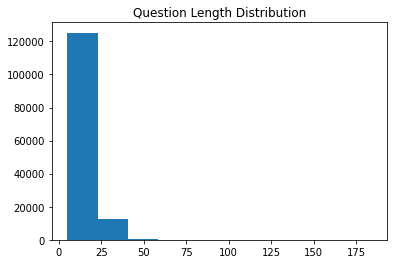

In [8]:
%matplotlib inline
plt.hist(q_len)
plt.title('Question Length Distribution')
plt.show()

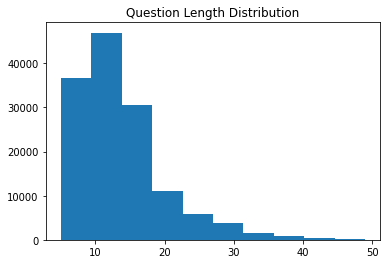

In [9]:
plt.hist([q for q in q_len if q < 50])
plt.title('Question Length Distribution')
plt.show()

In [10]:
print("Average length of question: ", sum(q_len)/len(q_len))
print("Average length of answer: ", sum(ans_len)/len(ans_len))

Average length of question:  13.796818996415771
Average length of answer:  1.6840169383743786


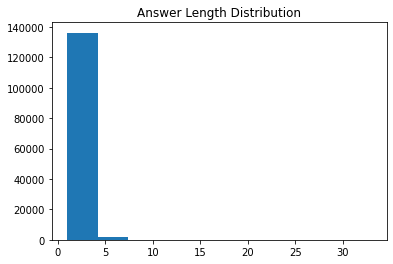

In [11]:
plt.hist(ans_len)
plt.title('Answer Length Distribution')
plt.show()

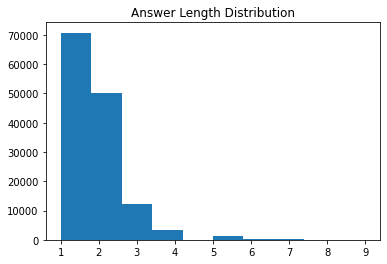

In [12]:
plt.hist([a for a in ans_len if a < 10])
plt.title('Answer Length Distribution')
plt.show()

In [13]:
print(len([a for a in ans_len if a < 5]))
print(len(ans_len))

136245
138384


In [ ]:
count = 0
for row in dataset['train']:
    ans = row['answer']['value'].replace('\n', '')
    ans_words = ans.split()
    if len(ans_words) > 20:
        count += 1
        print(row['question'])
        print(ans)
        print("--------")
    if count == 8:
        break

In [15]:
print(len([q for q in q_len if q < 50]))
print(len(q_len))

138147
138384


In [ ]:
count = 0
for row in dataset['train']:
    q = row['question'].replace('\n', '')
    q_words = q.split()
    if len(q_words) > 20:
        count += 1
        print(q)
    if count == 8:
        break

In [ ]:
clean_train_dataset = dataset['train'].filter(lambda x: len(x['answer']['value'].replace('\n', '').split()) < 5 
                                              and len(x['question'].replace('\n', '').split()) < 50)

In [ ]:
clean_train_dataset ## Not used in this version of the training below.

In [30]:
count = 0
for example in clean_train_dataset:
    print(example['question'], example['answer']['value'])
    count += 1
    if count == 10:
        break

Which American-born Sinclair won the Nobel Prize for Literature in 1930? Sinclair Lewis
Where in England was Dame Judi Dench born? York
In which decade did Billboard magazine first publish and American hit chart? 30s
From which country did Angola achieve independence in 1975? Portugal
Which city does David Soul come from? Chicago
Who won Super Bowl XX? Chicago Bears
Which was the first European country to abolish capital punishment? Norway
In which country did he widespread use of ISDN begin in 1988? Japan
What is Bruce Willis' real first name? Walter
Which William wrote the novel Lord Of The Flies? Golding


### 2. Preprocessing the training data

In [ ]:
model_name_or_path='t5-base'
tokenizer_name_or_path='t5-base'

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [22]:
tokenizer("This is the question sentence", "Potential answer here")

{'input_ids': [100, 19, 8, 822, 7142, 1, 22672, 1525, 270, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [23]:
len_all = []
for i, example in enumerate(clean_train_dataset):
    len_all.append(len(tokenizer(example['question'], example['answer']['value'])["input_ids"]))

print("avg token len: ", sum(len_all)/len(len_all))
print("max len: ", max(len_all))

avg token len:  25.453653192959756
max len:  148


In [24]:
max_length = 150        # I might truncate later. But going to keep the whole thing for now
doc_stride = 50         # The authorized overlap between parts of context when splitting is needed - won't be needed with max_length = 150.

tokenized_example = tokenizer(
    clean_train_dataset[20]['question'],
    clean_train_dataset[20]['answer']['value'],
    max_length = max_length,
    truncation = "only_first",  ## these params wont be used for now.
    return_overflowing_tokens = True,
    stride = doc_stride
)

tokenized_example

{'input_ids': [[2645, 47, 8, 163, 25727, 11874, 59, 12, 43, 3, 9, 2214, 564, 58, 1, 13995, 107, 25727, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'overflow_to_sample_mapping': [0]}

In [25]:
def clean_text(text):
    text = text.replace('Example of text:', '')
    text = text.replace('Example of Summary:', '')
    text = text.replace('\n','')
    text = text.replace('``', '')
    text = text.replace('"', '')

    return text

max_length_input = 150
max_length_output = 50

def preprocess_function(examples):
    inputs = [clean_text(doc) for doc in examples['question']]
    model_inputs = tokenizer(inputs,
                             max_length = max_length_input,
                             padding = 'max_length',
                             truncation = "only_first")
    
    with tokenizer.as_target_tokenizer():
        outputs = [clean_text(doc['value']) for doc in examples['answer']]
        labels = tokenizer(outputs,
                           max_length = max_length_output,
                           padding = 'max_length',
                           truncation = "only_first")

    model_inputs["target_input_ids"] = labels["input_ids"]
    model_inputs["target_attention_mask"] = labels["attention_mask"]
    return model_inputs

In [ ]:
tokenized_datasets = dataset.map(preprocess_function, batched = True)
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'target_input_ids', 'target_attention_mask'])

In [27]:
tokenized_datasets['train'].column_names

['answer',
 'attention_mask',
 'entity_pages',
 'input_ids',
 'question',
 'question_id',
 'question_source',
 'search_results',
 'target_attention_mask',
 'target_input_ids']

In [ ]:
## Use tokenized_datasets_subset for testing the model before running on whole.

from datasets import DatasetDict

num_samples = 100
rand_indices = np.random.choice(tokenized_datasets['train'].shape[0], num_samples, replace = False)
tokenized_datasets_subset = DatasetDict({'train': tokenized_datasets['train'].select(list(rand_indices)),
                                        'validation': tokenized_datasets['validation'].select(list(rand_indices)[:20]),
                                        'test': tokenized_datasets['test'].select(list(rand_indices)[:20])})

tokenized_datasets_subset

### 3. Modeling!

In [32]:
## utils.py

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def calculate_exact_match_score(prediction, ground_truth):
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))


def calculate_approx_match_score(prediction, ground_truth):
    answer = normalize_answer(prediction) 
    gt = normalize_answer(ground_truth)
    match = 0
    gt_words = gt.split(" ")
    for word in gt_words:
        if word in answer:
            match = 1
            return match
    return match


def calculate_match_score(predictions, ground_truths):
    exact_match_score = 0
    subset_match_score = 0
    for i in range(len(predictions)):
        ground_truth = ground_truths[i]
        prediction = predictions[i]
        exact_match_score +=  calculate_exact_match_score(prediction, ground_truth)
        subset_match_score += calculate_approx_match_score(prediction, ground_truth)
    
    exact_match_score /= len(predictions)
    subset_match_score /= len(predictions)
    return exact_match_score*100, subset_match_score*100

###### Use Pytorch Lightening module: https://pytorch-lightning.readthedocs.io/en/1.2.3/common/lightning_module.html
###### Best bit to understand which function is called when: https://pytorch-lightning.readthedocs.io/en/1.2.3/common/lightning_module.html#hooks


In [53]:
tokenized_datasets_for_model = tokenized_datasets_subset

class T5FineTuner(pl.LightningModule):

    def __init__(self, hparams):
        super(T5FineTuner, self).__init__()
        self.save_hyperparameters(hparams)
        self.model = T5ForConditionalGeneration.from_pretrained(self.hparams.model_name_or_path)
        self.tokenizer = AutoTokenizer.from_pretrained(self.hparams.tokenizer_name_or_path)
        self.model_dir = self.hparams.model_dir
        

    ## Reference: https://huggingface.co/transformers/model_doc/t5.html#t5forconditionalgeneration
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels):
        return self.model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = decoder_attention_mask,
            labels = labels,
            )


    def _step(self, batch):
        labels = batch['target_input_ids']
        ## set padding token label to = -100 so that it is ignored
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100
        outputs = self.forward(
            input_ids = batch['input_ids'],
            attention_mask = batch['attention_mask'],
            decoder_attention_mask = batch['target_attention_mask'],
            labels = labels
        )
        loss = outputs[0]
        return loss


    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.log('train_loss', loss, on_step = True, on_epoch = True, 
                 prog_bar = True, logger = True)
        return {"loss": loss}
    

    def training_epoch_end(self, training_step_outputs):
        avg_train_loss = torch.stack([x["loss"] for x in training_step_outputs]).mean()
        self.log('epoch_avg_train_loss: ', avg_train_loss, prog_bar = True)


    def train_dataloader(self):
        train_dataset = tokenized_datasets_for_model['train']
        sampler = RandomSampler(train_dataset)

        dataloader = DataLoader(train_dataset,
                                sampler = sampler,
                                batch_size = self.hparams.train_batch_size,
                                drop_last = True,
                                num_workers = 2)
        return dataloader


    def val_dataloader(self):
        validation_dataset = tokenized_datasets_for_model['validation']
        sampler = RandomSampler(validation_dataset)

        return DataLoader(validation_dataset,
                          batch_size = self.hparams.eval_batch_size,
                          sampler = sampler,
                          num_workers = 2)
    

    def configure_optimizers(self):
        ## Set bias decay to zero
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },]
        optimizer = AdamW(optimizer_grouped_parameters, lr = self.hparams.learning_rate)
        # decreasing learning rate (linear) after increasing in num_warmup_steps
        scheduler = get_linear_schedule_with_warmup(
            optimizer = optimizer,
            num_warmup_steps = self.hparams.warmup_steps,
            num_training_steps = self.hparams.training_steps
        )
        self.lr_scheduler = scheduler
        self.log('configured optimizer: ', optimizer)
        return optimizer


    def validation_step(self, batch, batch_idx):
        t0 = time.time()

        generated_ids = self.model.generate(
            input_ids = batch['input_ids'],
            attention_mask = batch['attention_mask'],
            use_cache = True,
            decoder_attention_mask=batch['target_attention_mask'],
            max_length = max_length_output,
            num_beams = 2,
            early_stopping = True
        )
        predictions = self._ids_to_clean_text(generated_ids)
        targets = self._ids_to_clean_text(batch["target_input_ids"])

        ## Calculate various metrics
        time_for_generation = (time.time() - t0) / batch["input_ids"].shape[0]
        loss = self._step(batch)

        mean_generated_ans_len = np.mean(list(map(len, generated_ids)))        
        exact_match_score, subset_match_score = calculate_match_score(predictions, targets)
        
        base_metrics = {'valuation_loss': loss,
                        'time_for_generation': time_for_generation,
                        'mean_gen_ans_len': mean_generated_ans_len,
                        'predictions': predictions,
                        'targets': targets,
                        'exact_match_score': exact_match_score,
                        'subset_match_score': subset_match_score
                        }
        self.log('val_loss', loss, prog_bar = True)
        self.log('exact_match_score', exact_match_score, prog_bar = True)
        self.log('subset_match_score', subset_match_score, prog_bar = True)

        return base_metrics


    ## helper functions
    def _ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids,
            skip_special_tokens = True,
            clean_up_tokenization_spaces = True
        )
        return list(map(str.strip, gen_text))
  


### 4. Train.

In [54]:
saved_models_path = '/content/drive/MyDrive/Colab\ Notebooks/trivia/saved_models'
logger = TensorBoardLogger(save_dir = os.getcwd(), version = 1)

args_dict = dict(
    model_dir               = saved_models_path, # path to save checkpoints
    resume_from_checkpoint  = None, ## set this to last checkpoint file you want to use in saved_models_path
    model_name_or_path      = 't5-base',
    tokenizer_name_or_path  = 't5-base',
    learning_rate           = 1e-5,
    weight_decay            = 0.0,
    adam_epsilon            = 1e-8,
    warmup_steps            = 0,
    train_batch_size        = 4,
    eval_batch_size         = 4,
    num_train_epochs        = 2,
    accumulate_grad_batches = 10,
    training_steps          = 1000,
    n_gpu                   = 1,
    val_check_interval      = 0.5, 
    early_stop_callback     = False,
    num_workers             = 0,
    fp_16                   = False,
    opt_level               = 'O1',
    max_grad_norm           = 1.0,
)

args = argparse.Namespace(**args_dict)

## Save checkpoints
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath = args.model_dir,
    filename = "{epoch}-{val_loss:.2f}", 
    monitor = "exact_match_score", 
    mode = "max", 
    save_top_k = 1
)

pl.seed_everything(42)
model = T5FineTuner(args)

train_params = dict(
    accumulate_grad_batches = 1,
    gpus = args.n_gpu,
    max_epochs = args.num_train_epochs,
    precision = 16 if args.fp_16 else 32,
    amp_level = args.opt_level,
    resume_from_checkpoint = args.resume_from_checkpoint,
    gradient_clip_val = args.max_grad_norm,
    checkpoint_callback = checkpoint_callback,
    val_check_interval = args.val_check_interval,
    callbacks=[],
    progress_bar_refresh_rate = 20,
    logger = logger
)

trainer = pl.Trainer(**train_params)
trainer.fit(model)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


### 5. ... And the model predicts:

In [ ]:
dataset = tokenized_datasets['validation']

loader = DataLoader(dataset, batch_size=32, shuffle=True)
it = iter(loader)

sample_batch = next(it)
sample_batch["input_ids"].shape

In [ ]:
T5_fine_tuner.to('cuda')
outputs = T5_fine_tuner.model.generate(
            input_ids = sample_batch['input_ids'].cuda(),
            attention_mask = sample_batch['attention_mask'].cuda(),
            use_cache = True,
            decoder_attention_mask = sample_batch['target_attention_mask'].cuda(),
            max_length = max_length_output,
            num_beams = 2,
            early_stopping = True
        )

def decode_id_seqs(ids):
    return tokenizer.batch_decode(
        ids, 
        skip_special_tokens = True,
        clean_up_tokenization_spaces = True
        )

In [ ]:
dec = decode_id_seqs(outputs)
texts = decode_id_seqs(sample_batch['input_ids'])
targets = decode_id_seqs(sample_batch['target_input_ids'])

In [ ]:
import textwrap

for i in range(10):
    lines = textwrap.wrap("Q:\n%s" % texts[i], width=100)
    print("\n".join(lines))
    print("Actual Answer: %s" % targets[i])
    print("Predicted: %s" % dec[i])
    print("==" * 10)

Q: Which Scot was Glenn Hoddle's assistant in the 'England job'?
Actual Answer: JOHN GORMAN
Predicted: JOHN BERGAN
Q: As well as municipalities, which country is made up of 26 states and one federal district?
Actual Answer: BRAZIL
Predicted: NORWAY
Q: Who was the first Tory Prime Minister of Great Britain (May, 1762 to July, 1765)?
Actual Answer: 3RD EARL OF BUTE
Predicted: JAMES JONES
Q: Every major league baseball team has retired the number 42, in honor of what player who was born
on January 31, 1919?
Actual Answer: Jackie Robinson
Predicted: JOHN HARRISON
Q: In which county did Eccles cakes originate
Actual Answer: Lancashire
Predicted: NORTHWICH
Q: Charlie Sheen starred as which character in the TV series Two and a Half Men?
Actual Answer: Charlie
Predicted: 'THE MONSTER'S MAN'
Q: Phlebitis refers to inflammation of what part of the human body?
Actual Answer: Veins
Predicted: The ear
Q: What scientist sailed on the HMS Beagle?
Actual Answer: Charles Darwin
Predicted: Sir Richard B

### 6. Test loading from checkpoint

In [ ]:
### Test loading from checkpoint:
saved_models_path = '/content/drive/MyDrive/Colab Notebooks/trivia/saved_models/'
checkpoint_file = 'checkpoint-checkpoint-t5-epoch=01-val_loss=2.79-v1.ckpt'
T5_fine_tuner_loaded = T5FineTuner.load_from_checkpoint(saved_models_path + checkpoint_file)


In [ ]:
T5_fine_tuner_loaded.eval()
T5_fine_tuner_loaded.to('cuda')

outputs_new = T5_fine_tuner_loaded.model.generate(
                input_ids = sample_batch['input_ids'].cuda(),
                attention_mask = sample_batch['attention_mask'].cuda(),
                use_cache = True,
                decoder_attention_mask = sample_batch['target_attention_mask'].cuda(),
                max_length = max_length_output,
                num_beams = 2,
                early_stopping = True
        )

dec_new = decode_id_seqs(outputs_new)

In [ ]:
for ans1, ans2 in zip(dec_new, dec):
    print(ans1, '\t\t\t\t\t', ans2)

#### Conclusion.

The predicted answers are very convincing! But Wrong!